<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# 🛍️ Launch New Products

Today you are a machine learning engineer at the Department of New Products at Target Cosmetics! 

We will start with a small dataset on interactions between users and current products from the past and try to discover substructure, if there's any, by applying some **unsupervised learning** methods. 

Then we will leverage the small amount of labeled data (current products) in combination with a larger amount of unlabeled data (new products to launch) to make estimations as to which products will sell more. 

## 📚 Learning Objectives

By the end of this session, you will be able to:

- apply dimensionality reduction techniques to reduce features to a lower dimensional space
- perform customer segmentation, determine optional number of clusters, and understand assumptions for used algorithm
- understand what semi-supervised learning is and leverage it to improve performance of supervised learning

## Task 1. Dimensionality Reduction

1. Load in the data. 
    
    Import `pandas` as `pd` and use `pd.read_csv()` to read in `past.csv.gz` in the `dat` folder, saving it as `past`. 
    
    Data in `past.csv.gz` was propcessed; e.g., features indicating time of day, day of week, month, and year of the purchase have been converted to one-hot representations of these categories. 

In [41]:
import pandas as pd
past = pd.read_csv("../dat/past.csv.gz")
past.columns


Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')

In [42]:
import numpy as np      
import pandas as pd     

import matplotlib.pyplot as plt  

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

<details>
<summary> Expected output </summary>

```
Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')
```
</details>

2. What percentage of the interactions (rows) resulted in a purchase?
    34%

    Do people mostly buy what they look at or do they do a lot of "window shopping" (shopping around without buying)?

    Most people do a lot of window shopping.
    
    From the perspective of classification, is the data balanced?

    No, the classificaion is not balanced, because 2/3 didn't result in purchase

In [147]:

past["Purchased?"].value_counts(normalize=True)


0    0.6562
1    0.3438
Name: Purchased?, dtype: float64

3. Drop `product_id` and `user_id` and save the rest columns to a new `pd.DataFrame`:`X`; then pop the column `'Purchased?'` and save it to `y`.

In [44]:
X = past.drop(["product_id", "user_id"], axis=1)
y = X.pop("Purchased?")

In [45]:
assert X.shape == (5000, 34)
assert y.shape == (5000,)

4. Apply [PCA (check documentation if unfamiliar)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the number of features down to **5**, save it to a numpy array named `X_reduced`. 

    Do you need to preprocess the data before performing PCA? Quick review [here: Importance of feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html).
    
    If time permits, read [Does mean centering or feature scaling affect a Principal Component Analysis?](https://sebastianraschka.com/faq/docs/pca-scaling.html) or [discussion 1](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance).

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scalar = StandardScaler()
x_scaled = scalar.fit_transform(X)
pca = PCA(n_components=5)
X_reduced = pca.fit_transform(x_scaled)

In [47]:
assert X_reduced.shape == (5000, 5)

5. Print out the percentage of variance explained by each of the selected components.

In [48]:
pca.explained_variance_ratio_

array([0.1028231 , 0.0944574 , 0.06514704, 0.05127256, 0.04287527])

6. Review code in functions `visualize_2pcs` and `visualize_3pcs` below and visualize first few principal components in 2D and 3D plots, respectively:

In [49]:
import matplotlib.pyplot as plt

def visualize_2pcs(pcs, y):
    fig, ax = plt.subplots()
    plot = plt.scatter(pcs[:,0], pcs[:,1], c=y) 
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

In [50]:
def visualize_3pcs(pcs, y):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(projection='3d')
    plot = ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=y)
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

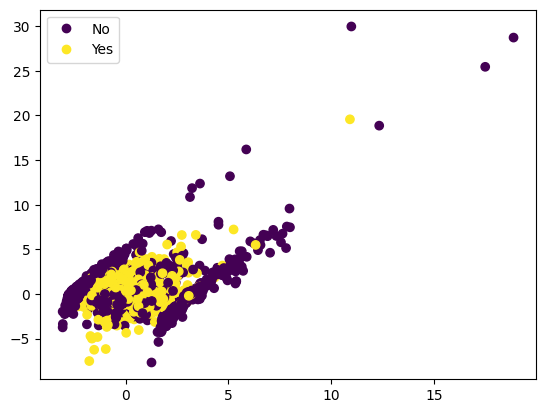

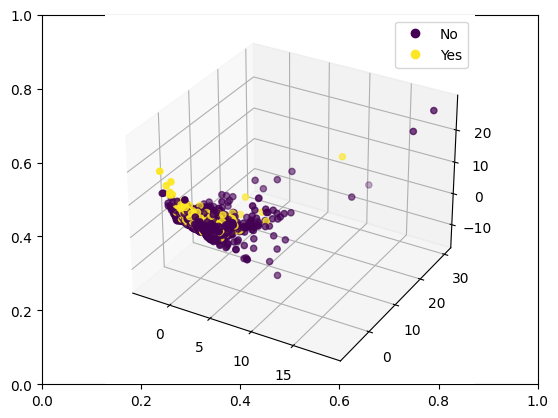

In [51]:
visualize_2pcs(X_reduced, y)
visualize_3pcs(X_reduced, y)

7. One way to assess the quality of the dimensionality reduction, when the groundtruth is available of course, is comparing the prediction performance using given features vs reduced (engineered) features.

    Complete the wrapper function below that 

    - takes features, target, and a boolean parameter indicating whether to include standardization in the pipeline or not
    - split the data into train (80%) and test (20%) datasets, set the random state for spliting at 0
    - build a pipeline that 

        1) preprocessing data using standardization if the `standardize` is `True`; otherwise skip this step  

        2) apply logistic regression ( are the labels balanced? )
        
    - fit the pipeline using training data
    - print the classification report (use `sklearn.metrics.classification_report`) on test data

In [52]:


def train(X, y, standardize = True) -> None:
    if (standardize):
        StandardScaler().fit_transform(X)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 0)
    model = LogisticRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred))
        

Now apply the pipeline on the all the features `X` and review the performance

In [53]:
train(X, y)

              precision    recall  f1-score   support

           0       0.65      0.99      0.78       649
           1       0.11      0.00      0.01       351

    accuracy                           0.64      1000
   macro avg       0.38      0.50      0.39      1000
weighted avg       0.46      0.64      0.51      1000



Similarly, apply the pipeline on the reduced / engineered features `X_reduced`. Should you include standardization in the pipeline?

In [54]:
train(X_reduced, y)

              precision    recall  f1-score   support

           0       0.64      0.96      0.77       649
           1       0.04      0.00      0.01       351

    accuracy                           0.62      1000
   macro avg       0.34      0.48      0.39      1000
weighted avg       0.43      0.62      0.50      1000



8. Are the results as expected? Discuss the pros and cons using reduced set of features in this application with your teammate. 


The reduced features dataset performed just as well as the original dataset. The pros of using reduced set of features is that this saves computation expenses, reduces overfitting, and leads to a more stable model. The cons are the possibility of model underfitting and information loss.

## Task 2. Customer Segmentation

In this task, we apply k-means clustering on the reduced data, experimenting different vaules of `n_cluster`, summarize all this information in a single plot, the *Elbow* plot. In addition, leverage silhouette visualization to help decide the "optimal" number of clusters in our data and answer: 

1. Are there any patterns among customer purchasing behaviors?
2. If so, what categories do they belong to? How do you characterize the clusters?
3. If not, what followup steps and / or recommendations will you make as an MLE?

1. Look up the [documentation](https://scikit-learn.org/stable/modules/clustering.html) and import the model class for k-means from `sklearn.cluster`

In [55]:
from sklearn.cluster import KMeans

2. Complete `visualize_elbow`; inspect the code and complete

    - fit k-means on the given data `X` and `k`, setting `random_state` to be 10 for reproducibility
    - append the sum of squared distances of samples to their closest cluster center for each $k$ to list `inertias`

In [56]:

def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    for k in ks:
        kmeans = KMeans(n_clusters = k, random_state=10).fit(X)
        inertias.append(kmeans.inertia_)
    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')

3. Visualize the elbow plot for the number of clusters ranging between 2 and 9. Discuss with your teammate, what is the 'optimal' number of clusters?

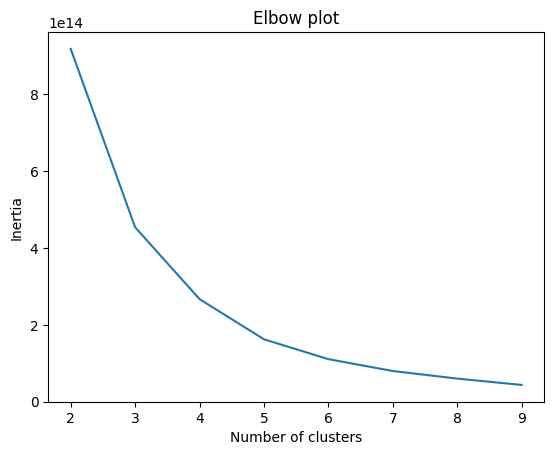

In [57]:
visualize_elbow(X, range(2, 10))

4. What are the disadvantage to use the Elbow method? 

The Elbow method gives a subjective estimate of the best number of clusters. In the graph above, 3, 4, 5 all could be candidates. 

5. Let's try a different approach: [silhouette score](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6).

    A helper function `visualize_silhouette` is provided for you (inspect the code in `utils.py`) and figure out how to use it to visualize k-means for k ranges from 2 to 8 on the reduced data. 

In [58]:
from utils import visualize_silhouette

For n_clusters = 2 The average silhouette_score is : 0.25082333255414097
For n_clusters = 3 The average silhouette_score is : 0.2587063080144422
For n_clusters = 4 The average silhouette_score is : 0.27234221742267517
For n_clusters = 5 The average silhouette_score is : 0.2773602911068238
For n_clusters = 6 The average silhouette_score is : 0.24328155497927104
For n_clusters = 7 The average silhouette_score is : 0.2481025757966278
For n_clusters = 8 The average silhouette_score is : 0.26272459099241935
For n_clusters = 9 The average silhouette_score is : 0.25584198386243706


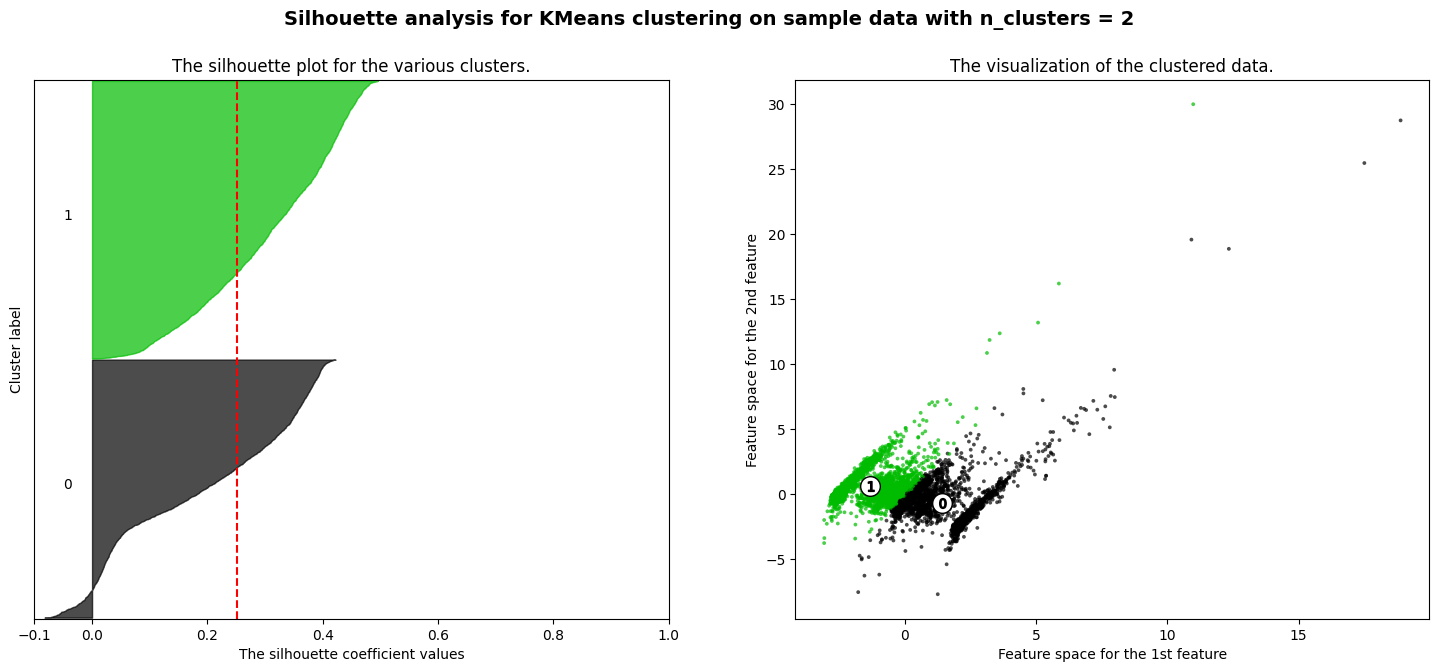

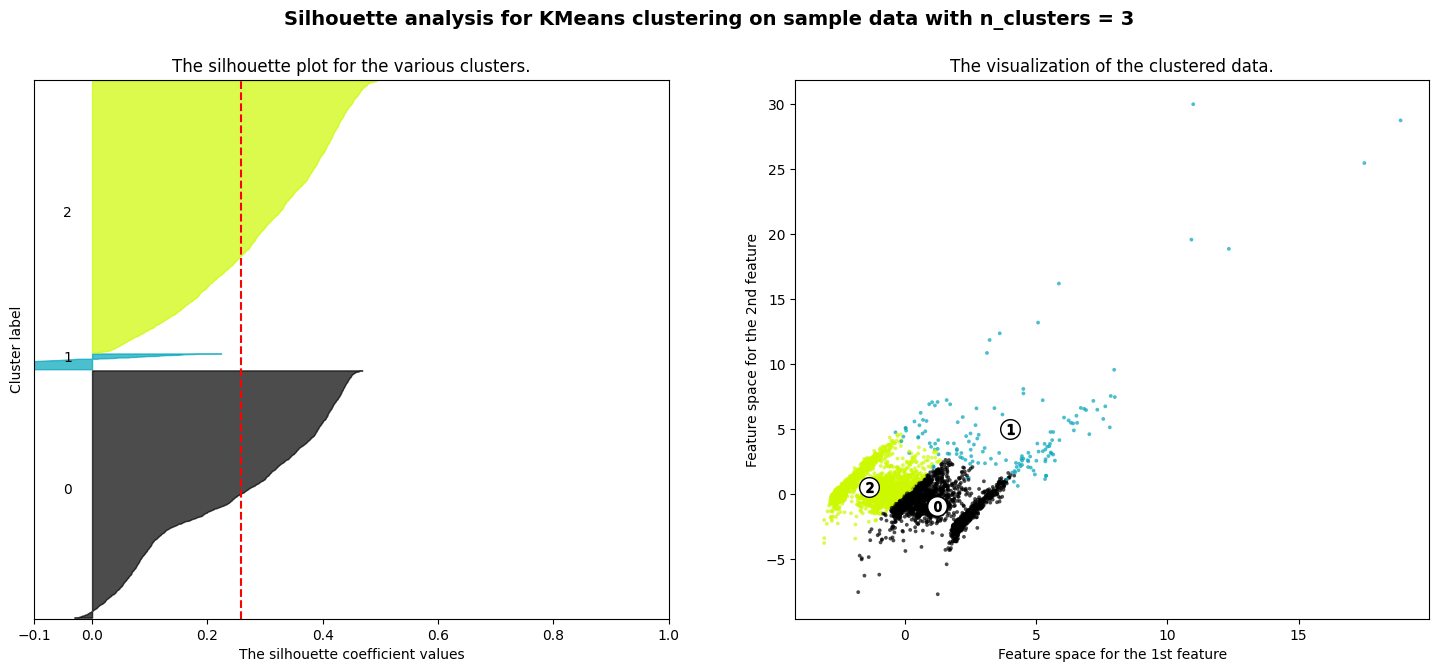

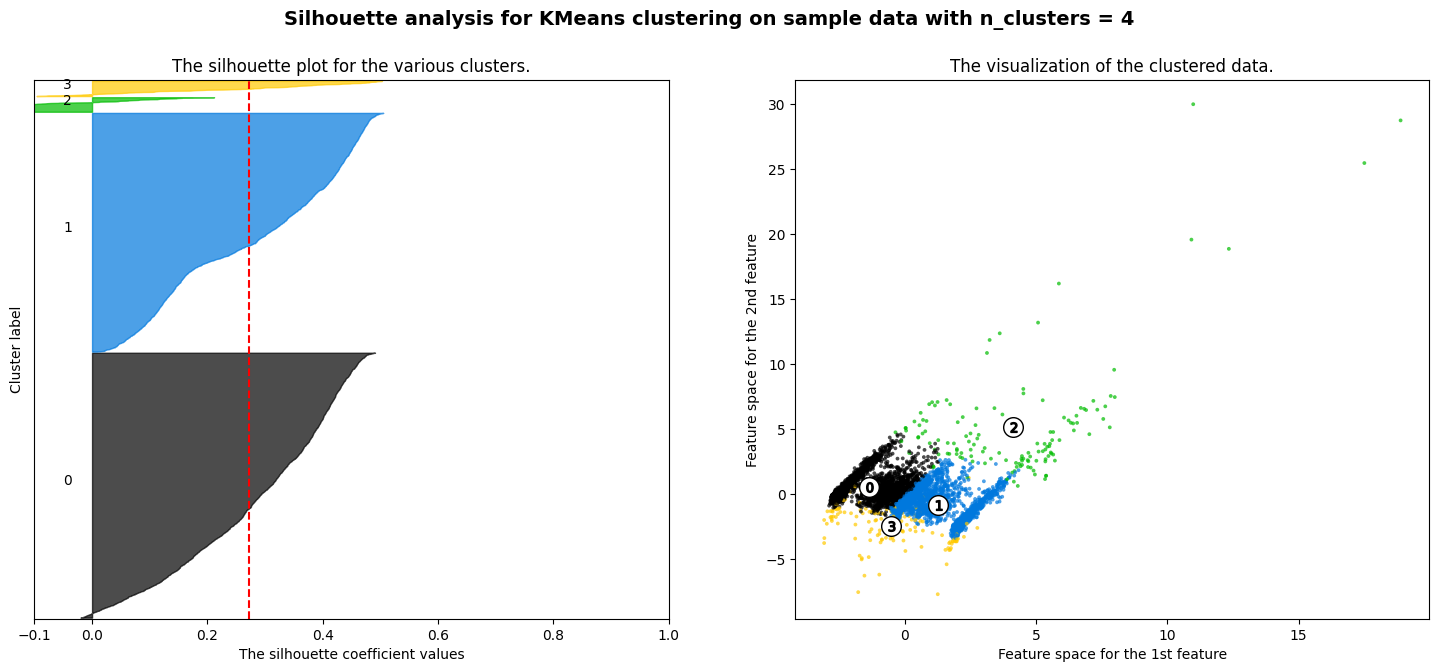

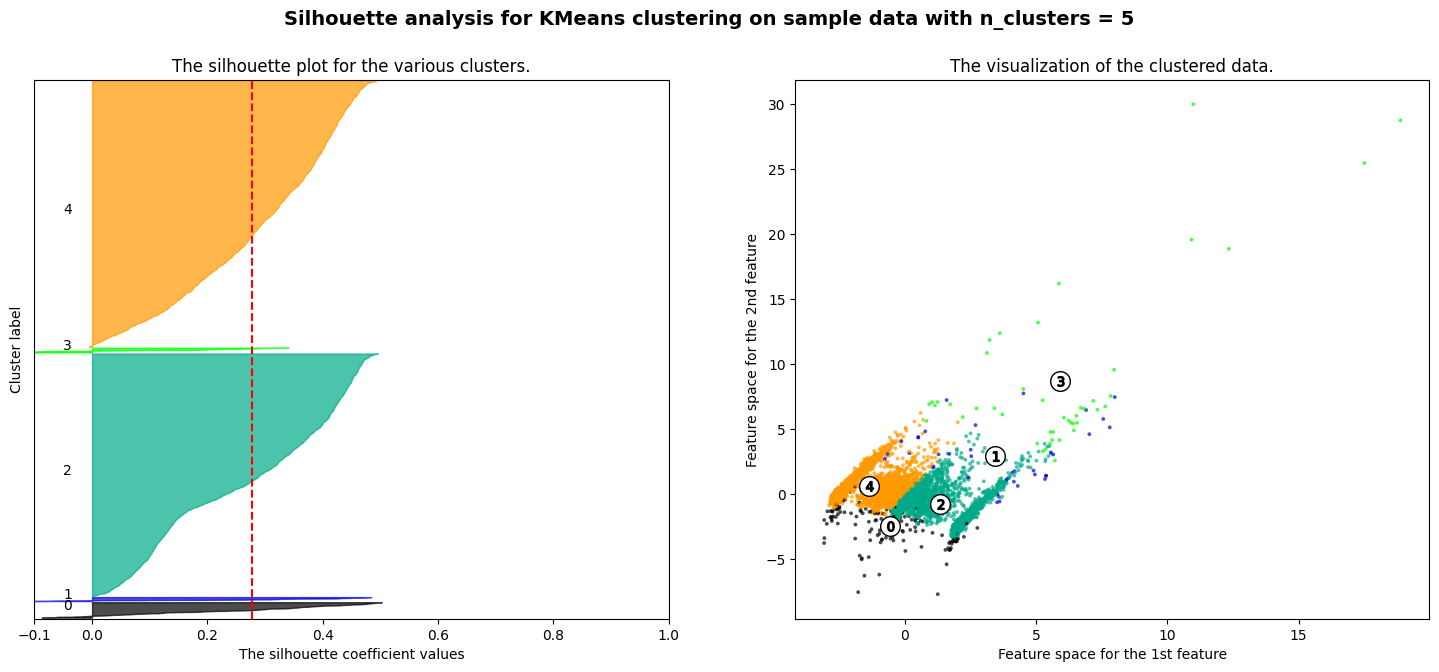

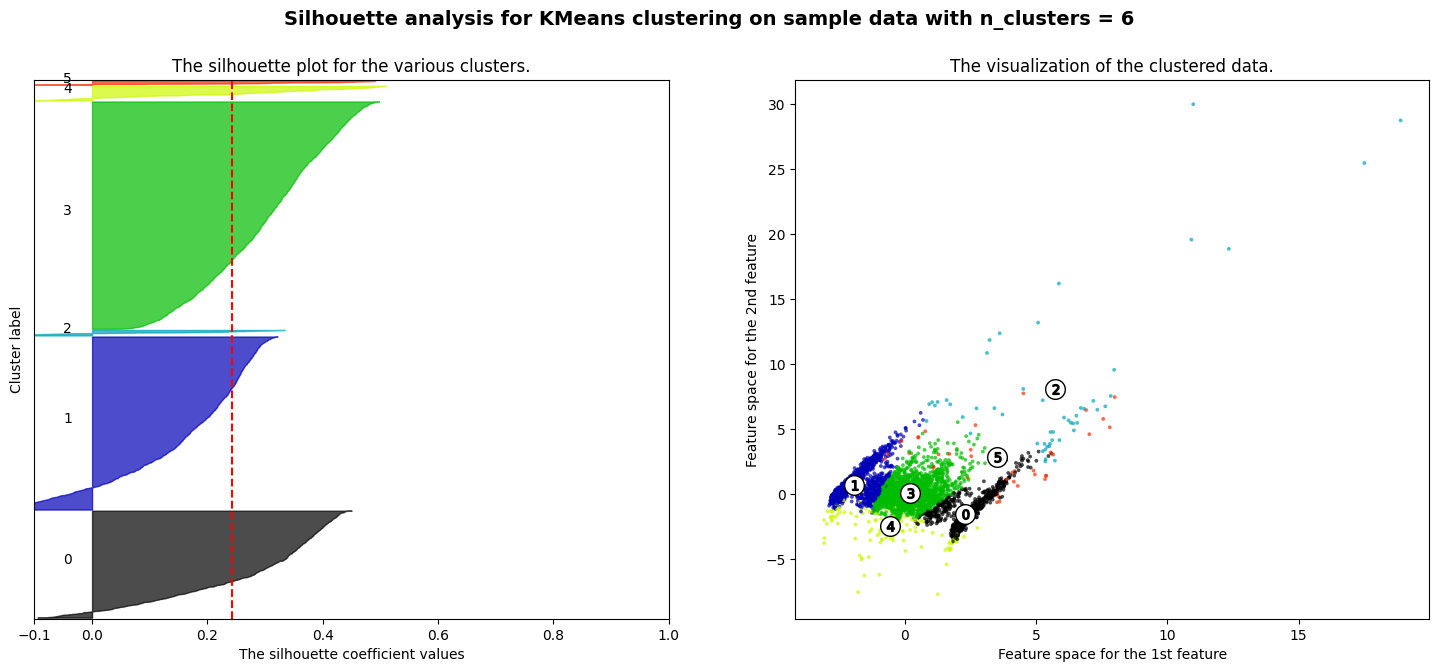

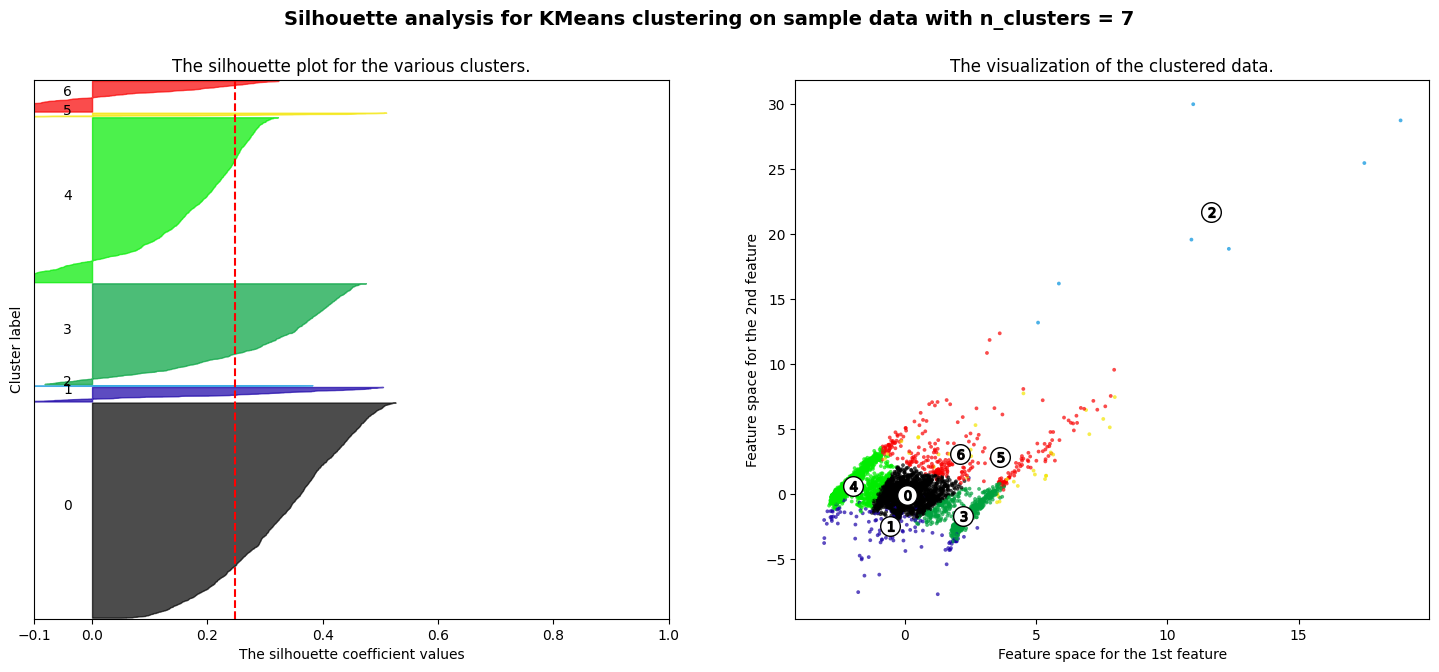

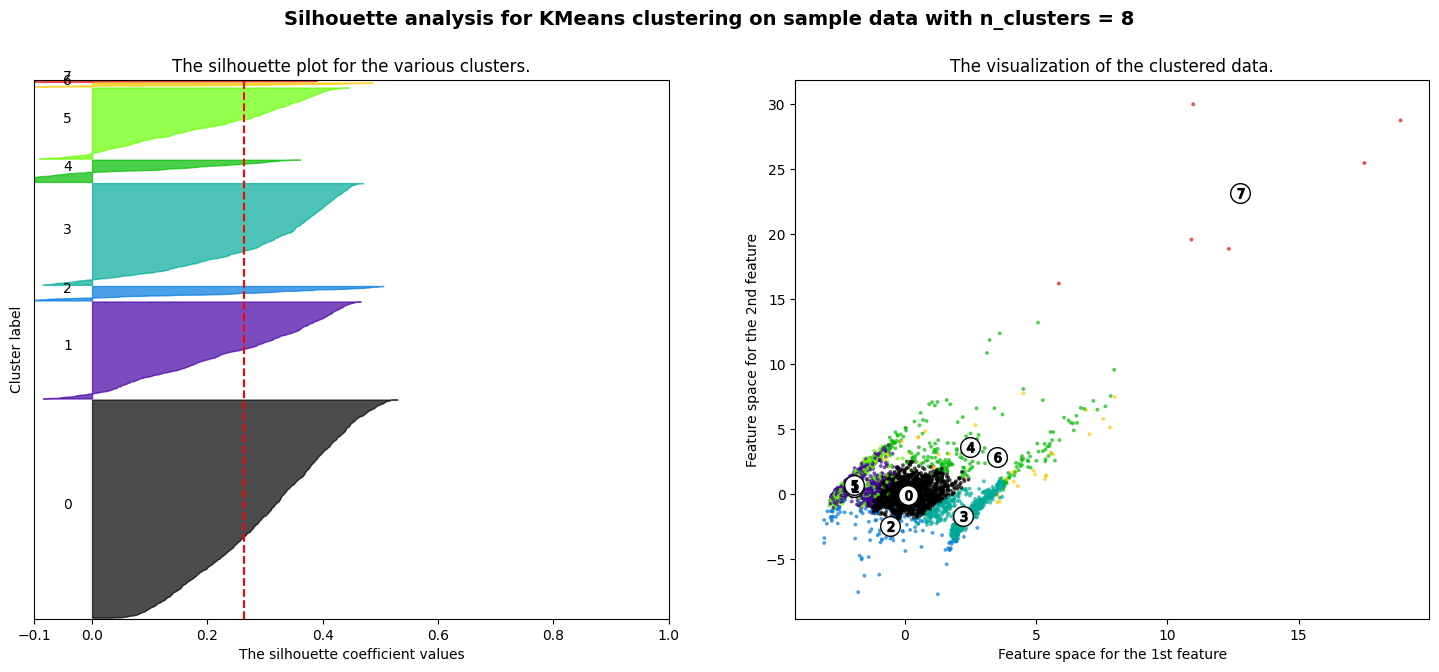

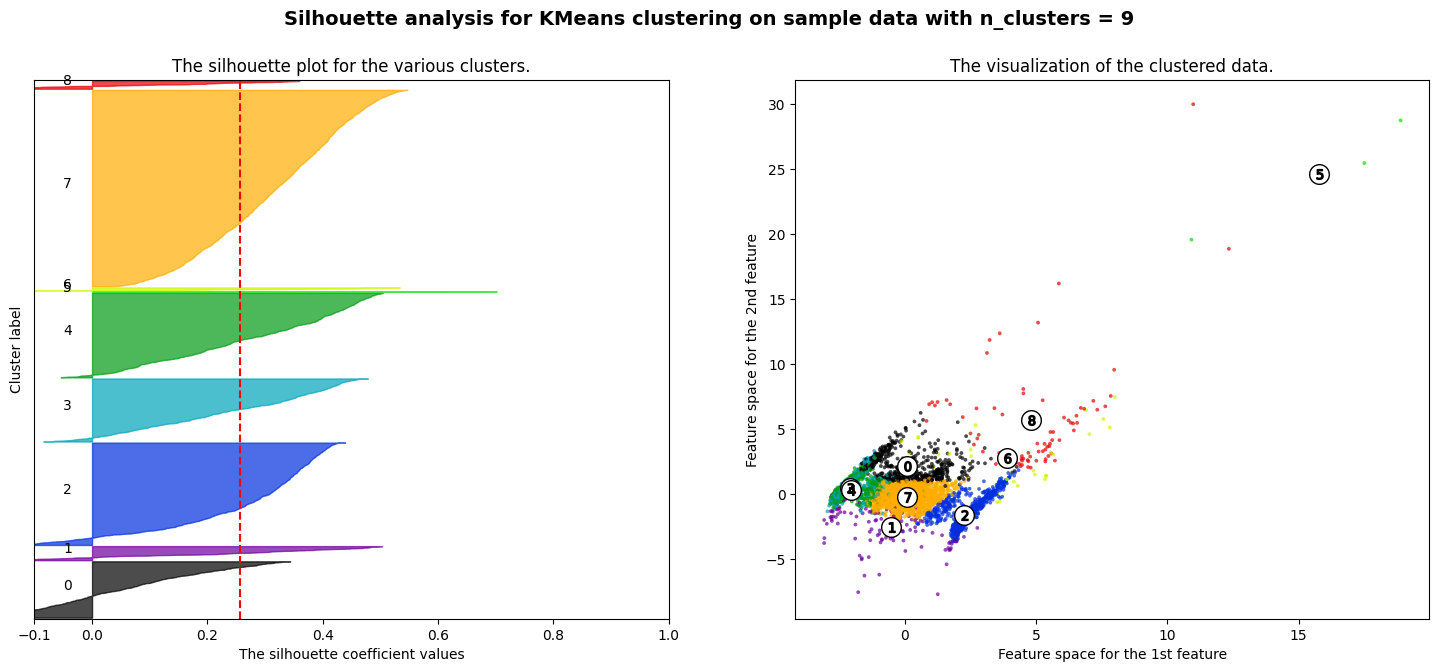

In [59]:
visualize_silhouette(9, X_reduced)

6. Instantiate a k-means model using the number of cluster that you deem optimal, assign it to `km`, and fit on the reduced data. 

In [60]:
km = KMeans(n_clusters=4, random_state=0)
km.fit(X_reduced)

KMeans(n_clusters=4, random_state=0)

7. What is the size of each cluster? 

In [61]:
import numpy as np
from scipy.cluster.vq import kmeans,vq
# assign each sample to a cluster
# idx,_ = vq(X_reduced, km)
labels = km.labels_

#Print number of elements per cluster
print(np.bincount(labels))

[2483  137 2237  143]


8. Create a new column called `cluster_pca` in `past`, with values as predicted cluster index predicted by `km`. 

In [62]:
past.loc[:,"cluster_pca"] = km.labels_

In [63]:
past.head(10)

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
0,5866936,5.618978e+08,1.333333,1.333333,5.550000e+03,15.84000,15.84000,0.000000,1.333333,0.000000,...,0.000000,0.0,0.666667,0.333333,0.000000,0.000000,0,0.00,1.000000,2
1,5647110,5.326529e+08,2.250000,1.500000,2.755650e+04,5.80000,5.56500,1.250000,0.250000,0.250000,...,0.750000,0.0,0.000000,0.250000,0.000000,0.000000,0,0.00,1.000000,2
2,5790472,4.578109e+08,1.000000,1.000000,0.000000e+00,6.27250,6.27250,0.250000,0.750000,0.000000,...,0.000000,0.0,0.000000,0.750000,0.250000,0.000000,0,0.00,1.000000,2
3,5811598,4.612641e+08,1.500000,1.500000,1.315325e+05,5.56000,5.56000,0.250000,1.000000,0.250000,...,0.000000,0.0,0.000000,0.500000,0.000000,0.250000,0,0.25,1.000000,2
4,5846363,5.157993e+08,1.875000,1.375000,1.105588e+04,4.08625,4.08625,0.500000,1.000000,0.250000,...,0.375000,0.0,0.125000,0.250000,0.250000,0.000000,1,0.00,1.000000,0
5,5826406,5.040005e+08,4.000000,3.333333,1.016038e+06,5.56000,5.50000,0.333333,2.666667,0.666667,...,0.333333,0.0,0.333333,0.333333,0.000000,0.000000,0,0.00,0.666667,0
6,5550698,5.744890e+08,1.454545,1.090909,5.469909e+03,4.41000,4.41000,0.272727,0.909091,0.090909,...,0.181818,0.0,0.181818,0.454545,0.090909,0.090909,1,0.00,1.000000,0
7,5787920,4.994029e+08,1.000000,1.000000,0.000000e+00,4.76000,4.76000,0.500000,0.000000,0.500000,...,0.000000,0.0,0.500000,0.500000,0.000000,0.000000,0,0.00,1.000000,0
8,5824146,3.815759e+08,2.800000,1.600000,1.725962e+05,4.88800,4.77600,1.000000,0.800000,0.800000,...,0.200000,0.0,0.400000,0.400000,0.000000,0.000000,1,0.00,1.600000,0
9,5695916,5.929000e+08,1.000000,1.000000,0.000000e+00,1.43000,1.43000,0.000000,1.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0,0.00,1.000000,2


9. Open ended: manipulate `past` and see if you can characterize each cluster (e.g., calculate statistics of / visualize features for each cluster), how will you intepret the results? 

    **Note**. This is probably the most important part as far as the business stakeholders are concerned: "*What can I do with your results?*" The math, modeling part is relatively easy, compared to actionable recommendations you make for business. Thus, before jumping on a different algorithm for the given task, do you best to 1) understand the data in depth 2) keep buisiness use cases in mind throughout all steps. 

 Once we have our clusters, we can treat each individual cluster as a unique dataset. We can apply feature engineering, descriptive statistic, even ML algorithms on each individual dataset. For example, we can calculate moments of each cluster, plot the distributions, calculate quantiles, probabilities, etc, and look for correlations. 

In [151]:
cluster_zero = past[past["cluster_pca"] == 0]
cluster_zero.describe()


,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
count,2.483000e+03,2.483000e+03,2483.000000,2483.000000,2.483000e+03,2483.000000,2483.000000,2483.000000,2483.000000,2483.000000,...,2483.000000,2483.000000,2483.000000,2483.000000,2483.000000,2483.000000,2483.000000,2483.000000,2483.000000,2483.0
mean,5.542780e+06,5.152590e+08,1.881177,1.287005,1.800967e+05,5.618325,5.598052,0.536806,0.846409,0.392548,...,0.207175,0.067494,0.165975,0.238957,0.175206,0.088042,0.355215,0.057151,1.127980,0.0
std,1.207444e+06,5.883358e+07,0.848854,0.383721,3.927131e+05,5.111193,5.107829,0.534469,0.529913,0.493872,...,0.270768,0.175495,0.252340,0.290034,0.259524,0.197456,0.478675,0.149434,0.398845,0.0
min,4.104000e+03,6.524181e+07,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,5.747406e+06,4.940293e+08,1.000000,1.000000,0.000000e+00,2.380000,2.380000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
50%,5.822827e+06,5.283095e+08,1.800000,1.166667,3.078750e+03,4.130000,4.120000,0.500000,1.000000,0.250000,...,0.125000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
75%,5.862663e+06,5.560560e+08,2.285714,1.466092,1.769605e+05,6.810909,6.726875,0.833333,1.000000,0.659420,...,0.333333,0.043478,0.250000,0.333333,0.250000,0.090909,1.000000,0.036376,1.000000,0.0
max,5.916644e+06,5.950013e+08,7.500000,4.000000,3.891687e+06,33.452500,33.452500,4.000000,4.333333,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,0.0


In [152]:
cluster_one = past[past["cluster_pca"]==1]
cluster_one.describe()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
count,1.370000e+02,1.370000e+02,137.000000,137.000000,1.370000e+02,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.0
mean,5.794898e+06,5.016689e+08,5.713759,3.062833,2.350019e+06,4.749813,4.507204,1.611233,2.010173,1.928945,...,0.211888,0.076844,0.133591,0.280007,0.112122,0.122404,0.175182,0.063144,2.119495,1.0
std,4.956932e+05,7.821851e+07,5.059902,3.300227,2.500102e+06,5.509924,5.543129,1.416538,3.804151,3.350017,...,0.346093,0.224149,0.283243,0.386734,0.269114,0.287703,0.381518,0.215361,1.210711,0.0
min,8.919000e+04,1.319941e+08,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,5.803104e+06,4.678101e+08,3.000000,2.000000,4.467220e+05,1.590000,1.430000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
50%,5.850332e+06,5.177758e+08,5.000000,2.000000,1.469744e+06,3.810000,3.173333,1.000000,0.750000,1.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.0
75%,5.889137e+06,5.487606e+08,6.105263,3.000000,3.670985e+06,5.710000,5.560000,2.000000,2.333333,2.000000,...,0.333333,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,3.000000,1.0
max,5.931329e+06,6.100017e+08,40.000000,28.000000,1.087537e+07,51.080000,51.080000,12.000000,28.000000,38.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.0


In [153]:
cluster_two = past[past["cluster_pca"]==2]
cluster_two.describe()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
count,2.237000e+03,2.237000e+03,2237.000000,2237.000000,2.237000e+03,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,...,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.0
mean,5.600912e+06,5.332799e+08,1.830116,1.274837,2.066024e+05,6.328401,6.298969,0.509153,0.856601,0.365909,...,0.219292,0.064141,0.158601,0.250992,0.165215,0.081946,0.337506,0.059812,1.107399,2.0
std,1.118586e+06,5.855869e+07,0.797801,0.363101,4.874872e+05,5.849606,5.830355,0.435551,0.539698,0.476096,...,0.277764,0.168112,0.235929,0.284501,0.243079,0.178337,0.472965,0.151453,0.317863,0.0
min,4.185000e+03,1.219156e+08,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,5.770344e+06,5.077677e+08,1.000000,1.000000,0.000000e+00,2.609333,2.593077,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.0
50%,5.839287e+06,5.406385e+08,1.714286,1.166667,2.429000e+03,4.633333,4.600000,0.500000,1.000000,0.200000,...,0.142857,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,1.000000,2.0
75%,5.884340e+06,5.718011e+08,2.200000,1.500000,1.900417e+05,7.620000,7.600000,0.833333,1.000000,0.555556,...,0.333333,0.038462,0.250000,0.400000,0.250000,0.090909,1.000000,0.045455,1.000000,2.0
max,5.932538e+06,6.220262e+08,5.500000,4.000000,5.608663e+06,35.560000,35.560000,4.500000,4.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.0


(array([15., 30., 15., 16., 14., 21.,  4.,  4.,  3.,  6.,  0.,  0.,  0.,
         2.,  3.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.    ,  1.0216,  2.0432,  3.0648,  4.0864,  5.108 ,  6.1296,
         7.1512,  8.1728,  9.1944, 10.216 , 11.2376, 12.2592, 13.2808,
        14.3024, 15.324 , 16.3456, 17.3672, 18.3888, 19.4104, 20.432 ,
        21.4536, 22.4752, 23.4968, 24.5184, 25.54  , 26.5616, 27.5832,
        28.6048, 29.6264, 30.648 , 31.6696, 32.6912, 33.7128, 34.7344,
        35.756 , 36.7776, 37.7992, 38.8208, 39.8424, 40.864 , 41.8856,
        42.9072, 43.9288, 44.9504, 45.972 , 46.9936, 48.0152, 49.0368,
        50.0584, 51.08  ]),
 <BarContainer object of 50 artists>)

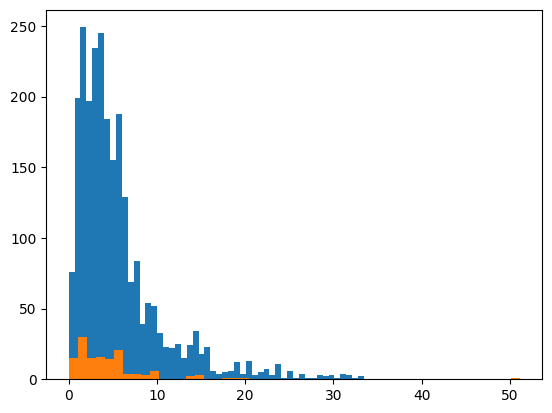

In [172]:
plt.hist(cluster_zero.maxPrice, 50)
plt.hist(cluster_one.maxPrice, 50)


10. What are the assumptions for k-means? Judging by the cluster sizes, is k-means a good approach? 

    Scanning the list of [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html) implemented in scikit-learn, try at least one other algorithm, examine its assumptions, and intepret results.

1. k-means assume the variance of the distribution of each attribute (variable) is spherical;

2. all variables have the same variance;

3. data distribution is normal;

The prior probability for all k clusters are the same, i.e. each cluster has roughly equal number of observations; If any one of these 3 assumptions is violated, then k-means will fail.

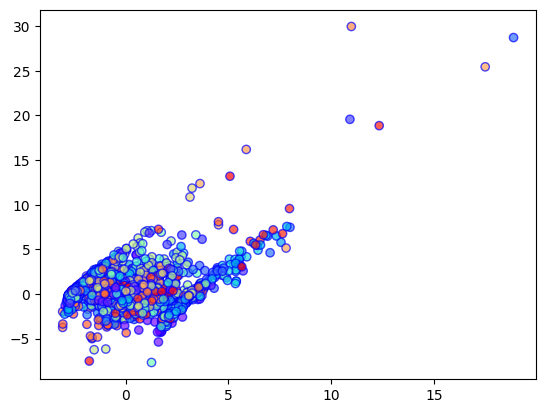

In [156]:
from sklearn.cluster import AffinityPropagation
# sc = SpectralClustering(n_clusters=4, n_init=100, assign_labels='discretize')
# sc.fit_predict(X_reduced)  
clustering = AffinityPropagation(random_state=0)
clustering.fit_predict(X_reduced)
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=clustering.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')

11. Jot down recommendations or followup steps, detailing the reasons.

    *YOUR ANSWER HERE*

## Task 3. To launch or not to launch?

In this task, we will work on a hypothetical application: cosmetics purchase prediction for new products with limited features. The intention here is to maximize **recall** so that no popular cosmetic is understocked. Overstocking is less of a concern since it will not cause disengagement in customers.

The purchase status for each "new" product is known, but we only use the labels for benchmarking purpose. Instead, we use label spreading method to leverage a small amount of labeled data in combination with a larger amount of unlabeled data. 

1. Read in the data in `new.csv.gz` and save it as a `pd.DataFrame` named `new`. This is the test dataset.

    Look at the shape of `new` and inspect the frist few rows.

In [67]:
new = pd.read_csv("../dat/new.csv.gz")
new.columns

Index(['product_id', 'maxPrice', 'minPrice', 'Purchased?', 'Category'], dtype='object')

In [68]:
assert new.shape == (30091, 5)

In [133]:
new.head()

,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


In [173]:
new["Purchased?"].value_counts()

0    19732
1    10359
Name: Purchased?, dtype: int64

2. How does the number of data points in the training set (`past`) compare to the number of datapoints in the test set (`new`)? 

    And how does the feature set in the training set compare to the feature set in the test set?



There are 6 times as many data points in new than in past, but there are a lot more features in past than in new. They share 5 common features. 

3. Are there any product ids in both the training and test datasets? Hint: use `np.intersect1d` or set operations.

In [72]:
np.intersect1d(past, new)

array([0.000e+00, 5.000e-02, 8.000e-02, ..., 5.013e+03, 5.143e+03,
       6.950e+03])

4. What percentage of data points resulted in a purchase in the test set?

    In reality, we won't be able to calculate information that is not available to you. Here, we simply demonstrated that the distributions in target between `past` and `new` are similar. 

In [176]:
new["Purchased?"].value_counts(normalize = True)

0    0.655744
1    0.344256
Name: Purchased?, dtype: float64

5. Create `ndarray`s: `X_train`, `y_train`, `X_test`, and `y_test` according to the following guidelines.

    - The `Purchased?` column is the target.
    - `X_train` and `X_test` should contain the same features
    - `product_id` should not be a feature.

    Double check that the shapes of the four arrays are what you expect.

In [94]:

X_train = past[["maxPrice", "minPrice", "Purchased?", "Category"]]
y_train = X_train.pop("Purchased?")

X_test = new.drop(["product_id"], axis=1)
y_test = X_test.pop("Purchased?")

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()



In [95]:
assert X_train.shape[0] == y_train.shape[0] # 5000
assert X_train.shape[1] == X_test.shape[1]  # 3

assert type(X_train) == np.ndarray # make sure you import numpy as np at this point
assert type(X_train).__module__ == type(y_train).__module__ == np.__name__  # alternative way

6. Let's fit a simple logistic regression on the training set (`X_train`, `y_train`) and report performance on the test set (`X_test`, `y_test`).

In [101]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.96      0.78     19732
           1       0.43      0.06      0.11     10359

    accuracy                           0.65     30091
   macro avg       0.54      0.51      0.44     30091
weighted avg       0.58      0.65      0.55     30091



7. Re-assemble data for semi-supervised learning. 
    - Use the features from the test set along with the features from the training set. 
    - Only use the labels from the training set but none from the test set.  
    
    Since we're using a large number of sampled features, but only a small number of these samples have labels, this is **semi-supervised learning**.

Create a matrix `X` that has the rows from `X_train` concatenated with the rows from `X_test`. Check the shape of the matrix.

In [122]:
X = np.concatenate((X_test, X_train), axis=0)

In [123]:
assert X.shape == (35091, 3)

Create the target array `y` by concatenating `y_train` with a vector of -1's, effectively creating a dummy label for the `X_test` rows in `X`. Check the shape of the array. It should have as many values as `X` has rows.

In [124]:
label_y = np.full((y_test.shape[0], ), -1)
print(y_train.shape)
print(label_y.shape)
y = np.concatenate((label_y, y_train), axis = 0)


(5000,)
(30091,)


In [125]:
assert X.shape[0] == y.shape[0]

8. Semi-supervised learning. 

    Scikit-learn provides two label propagation models: [`LabelPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) and [`LabelSpreading`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html). Both work by constructing a similarity graph over all items in the input dataset. `LabelSpreading` is similar to the basic Label Propagation algorithm, but it uses an affinity matrix based on the normalized graph Laplacian and soft clamping across the labels; thus more robust to noise. We will be using scikit-learn's `LabelSpreading` model with `kNN`.
    
    Train a `LabelSpreading` model. Set `kernel` to `knn` and `alpha` to 0.01.

In [126]:
from sklearn.semi_supervised import LabelSpreading

label_sprd_model = LabelSpreading(kernel = "knn", alpha=0.01)
label_sprd_model.fit(X, y)



LabelSpreading(alpha=0.01, kernel='knn')

9. Extract the predictions for the test data. 

    You can get the predictions from the `transduction_` attribute. Note that there is a value for every row in `X`, so select just the values that correspond to `X_test`.

In [127]:
semi_sup_preds = label_sprd_model.transduction_[:X_test.shape[0]]

In [128]:
assert semi_sup_preds.shape[0] == X_test.shape[0]

10. Print the classification report

In [130]:
print(classification_report(y_test, semi_sup_preds)) # make sure you properly import classification_report

              precision    recall  f1-score   support

           0       0.81      0.93      0.87     19732
           1       0.81      0.60      0.69     10359

    accuracy                           0.81     30091
   macro avg       0.81      0.76      0.78     30091
weighted avg       0.81      0.81      0.81     30091



Let's bring the performance from the supervised learning model down to see the comparison; discuss the areas of improvement and reasons for improvement.

In [131]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.96      0.78     19732
           1       0.43      0.06      0.11     10359

    accuracy                           0.65     30091
   macro avg       0.54      0.51      0.44     30091
weighted avg       0.58      0.65      0.55     30091



Semi-supervised learning 

11. Read [Small Data Can Play a Big Role in AI](https://hbr.org/2020/02/small-data-can-play-a-big-role-in-ai) and discuss with your teammate about AI tools for training AI with small data and their use cases. 

## Acknowledgement & References

- data was adapted from Kaggle: [eCommerce Events History in Cosmetics Shop](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop)
- function `visualize_silhouette` was adapted from [plot_kmeans_silhouette_analysis by scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Categorizing Online Shopping Behavior from Cosmetics to Electronics: An Analytical Framework](https://arxiv.org/pdf/2010.02503.pdf)
- [OPAM: Online Purchasing-behavior Analysis using Machine learning](https://arxiv.org/pdf/2102.01625.pdf)